<a href="https://colab.research.google.com/github/mlccgkpol/makeMore/blob/main/ml_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-07-31 06:25:23--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-07-31 06:25:24 (5.98 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [22]:
n_embed = 10 # no of dimensions
n_hidden = 200 # no of neurons in hidden layer

g = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embed),            generator=g)
W1 = torch.randn((n_embed * block_size), n_hidden, generator=g) * (5/3)/((n_embed * block_size)**0.5) ## kaiming init.
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 #intial tanh should be near zero (refer notes).
W2 = torch.randn((n_hidden, vocab_size),              generator=g) * 0.01 # reduce W2 since logits = h @ W2 and we want logits to be near zero and do not explode initially
b2 = torch.randn(vocab_size,                       generator=g) * 0 ## since we want to be logits to be near zero.

bngains = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,b1,W2,b2, bngains, bnbias]
for p in parameters:
  p.requires_grad = True

tensor(-0.0016) X_temp mean tensor(1.0047)
tensor(0.0034) y mean tensor(0.6365)


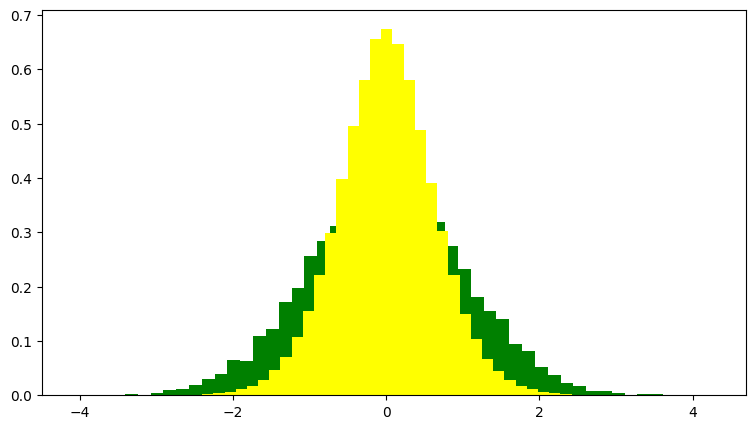

In [7]:
X_temp = torch.randn((1000,10))
w = torch.randn((10,200)) * 0.2
y = X_temp @ w
print(X_temp.mean(),"X_temp mean", X_temp.std())
print(y.mean(),"y mean", y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(X_temp.view(-1).tolist(), 50, density = True, color="green");
plt.subplot(121)
plt.hist(y.view(-1).tolist(), 50, density = True,color="yellow");

You can see the gausian of y is expanding, meaning standard deviation is increasing which we dont want since we want the distribution to be as much gaussian as possible.

In [23]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
  #mini batch construction
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embCat = emb.view(emb.shape[0],-1) #concat the vectors
  hpreact = embCat @ W1 #+b1 # no need to use b1 since we are substracting bnmeani which will diminish the b1 gradient, removind this.
  bnmeani = hpreact.mean(0,keepdim=True)
  bnstdi = hpreact.std(0,keepdim=True)
  hpreact = bngains*((hpreact - bnmeani)/bnstdi) + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i%10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.314689
  10000/ 200000: 2.198443
  20000/ 200000: 2.337455
  30000/ 200000: 2.435885
  40000/ 200000: 2.011928
  50000/ 200000: 2.259472
  60000/ 200000: 2.477500
  70000/ 200000: 2.101999
  80000/ 200000: 2.278812
  90000/ 200000: 2.186207
 100000/ 200000: 1.947383
 110000/ 200000: 2.301028
 120000/ 200000: 1.983655
 130000/ 200000: 2.452322
 140000/ 200000: 2.383932
 150000/ 200000: 2.198680
 160000/ 200000: 1.973299
 170000/ 200000: 1.866808
 180000/ 200000: 1.997269
 190000/ 200000: 1.834683


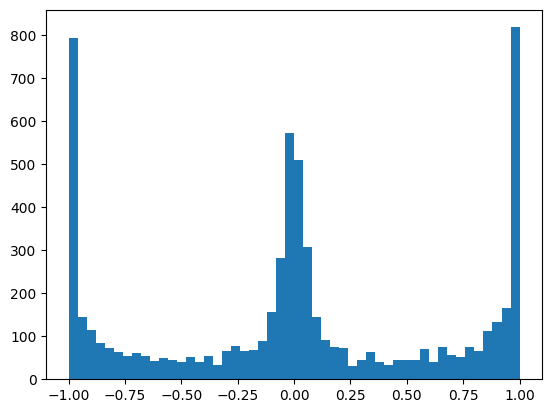

In [9]:
plt.hist(h.view(-1).tolist(), 50);

In [25]:
print(b1.grad)

tensor([-9.3132e-10,  0.0000e+00, -1.1642e-10, -2.3283e-10, -4.6566e-10,
         1.8626e-09, -2.3283e-10,  0.0000e+00,  9.3132e-10,  9.3132e-10,
        -2.3283e-10, -1.8626e-09, -1.8626e-09,  9.3132e-10,  2.7940e-09,
         9.3132e-10,  2.3283e-10,  9.3132e-10, -2.3283e-10, -2.3283e-09,
        -6.9849e-10,  0.0000e+00,  2.3283e-10,  9.3132e-10, -1.6298e-09,
        -1.3970e-09, -1.1642e-10,  3.7253e-09,  1.0477e-09,  1.1642e-10,
         2.7940e-09,  2.3283e-09,  0.0000e+00, -8.7311e-10,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -1.8626e-09,  9.3132e-10, -1.3970e-09,
         0.0000e+00, -2.0955e-09,  1.8626e-09, -3.4925e-10,  9.3132e-10,
         1.7462e-09,  9.3132e-10, -1.3970e-09,  0.0000e+00, -6.9849e-10,
        -1.8626e-09, -9.3132e-10, -3.4925e-10,  2.3283e-09, -4.6566e-10,
         0.0000e+00,  1.1642e-09,  3.9581e-09,  1.3970e-09,  9.3132e-10,
         9.3132e-10, -9.3132e-10, -1.1642e-10,  3.7253e-09,  4.6566e-10,
        -9.3132e-10, -1.3970e-09,  4.6566e-10, -4.6

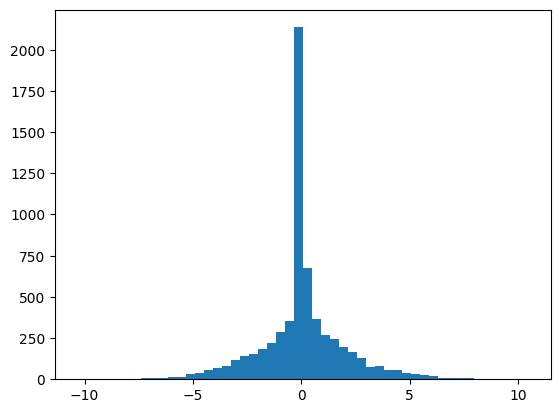

In [10]:
plt.hist(hpreact.view(-1).tolist(), 50);

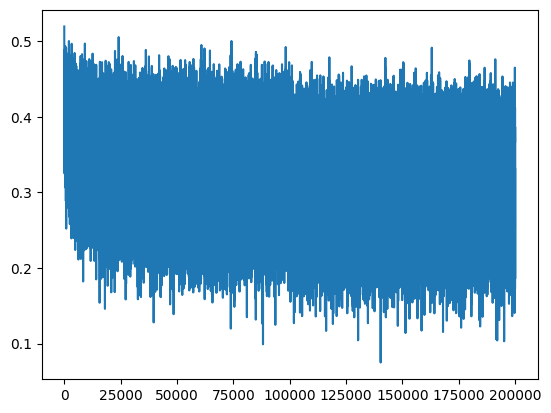

In [11]:
plt.plot(lossi)

In [24]:
@torch.no_grad() # this decorator disables gradient tracking.
def split_less(split):
  X,Y = {
      'train': (Xtr, Ytr),
      'dev': (Xdev,Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[X]
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  hpreact = bngains*((hpreact - bnmean_running)/bnstd_running) + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y)
  print(f'{split} Loss: ', loss.item())
print(split_less("train"))
print(split_less("dev"))

train Loss:  2.06659197807312
None
dev Loss:  2.1050572395324707
None


In [13]:
## initialization..
# uniform distribution (prob of any character roughly equal to 1/27)
#we want logits to be near zero when model is initialized.
#can we initialize W == 0??
  #


In [14]:
#4-d example
logits = torch.tensor([0,0,0,0]).float()
probs = torch.softmax(logits,dim = 0)
loss = -probs[2].log()
probs,loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))